In [ ]:
!pip install transformers
!pip install datasets
!pip install accelerate
!pip install evaluate

# Corpus acquisition

## Manual corpus scraping with Beautiful Soup

In [2]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import re
import time

In [3]:
url = "https://www.dailymail.co.uk"

In [4]:
request_dailymail = requests.get(url)
page = request_dailymail.content
soup1 = BeautifulSoup(page, 'html5lib')
page_news = soup1.find_all('h2', class_='linkro-darkred')

In [5]:
#nombre de news récupérés
len(page_news)

132

In [8]:
page_news[0]

<h2 class="linkro-darkred">
      <a href="/news/article-12122361/Tina-Turner-shared-Instagram-post-saying-wished-shed-taken-better-care-kidneys.html" itemprop="url">
          Tina Turner shared ominous Instagram post saying she wished she'd taken better care of her kidneys two months before her death aged 83
      </a>
  </h2>

In [9]:
number_of_articles = 10

In [10]:
# L'objectif est de récupérer des articles en se basant 
# sur l'url complet des articles récupérés avec la fonction find en utilisant 
# l'élément et l'attribut spécifique.
articles = []
for n in np.arange(0, number_of_articles):
        
    # Récupération des liens des articles
    link = url + page_news[n].find('a')['href']    
    # Extraction des titres
    title = page_news[n].find('a').get_text()    
    # Extraction du contenu de l'article sous forme de bloc
    article = requests.get(link)
    article_content = article.content
    soup_article = BeautifulSoup(article_content, 'html5lib')
    body = soup_article.find_all('p', class_='mol-para-with-font')
    # Fusionner le contenu de l'article en un seul texte
    list_paragraphs = []
    for p in np.arange(0, len(body)):
        paragraph = body[p].get_text()
        list_paragraphs.append(paragraph)
        final_article = " ".join(list_paragraphs)
    # nettoyage du texte pour enlever les caractères spéciaux lors du scrapping
    title = re.sub("\n", "", title)
    final_article = re.sub("\\xa0", "", final_article)
    # Create a dictionary for the article
    article_data = {'Title': title, 'Text': final_article,'Link':link}
    # Append the article to the list
    articles.append(article_data)

In [11]:
# Create a DataFrame from the list of articles
df = pd.DataFrame(articles)

## Corpus scraping with Newspaper3k

In [ ]:
!pip3 install newspaper3k

In [13]:
import newspaper
import pandas as pd

URLs to scrape using the newspaper library

In [14]:
BASE_URL = [
    'http://www.huffingtonpost.com',
    'http://cnn.com',
    'http://www.time.com',
    'http://www.cnbc.com',
    'http://www.foxnews.com',
    'http://theatlantic.com',
    'http://www.bbc.co.uk',
    'http://espn.com',
    'http://www.businessinsider.com',
    'http://www.sci-news.com',
    'http://www.gamefaqs.com',
    'http://www.health.com',
    'http://www.theinsider.com',
    'http://cnet.com',
    'http://nytimes.com',
    'http://www.nbcnews.com',
    'http://www.nasa.gov',
    'http://www.weather.com',
    'http://www.foxbusiness.com',
    'http://washingtontimes.com',
    'http://mashable.com',
    'http://www.forbes.com',
    'http://news.sky.com',
    'http://www.economist.com',
    'http://thinkprogress.org',
    'http://medium.com',
]

In [15]:
def scrape_articles(base_urls):
    scraped_urls = set()  # Set to store the scraped article URLs
    articles = []  # List to store the scraped articles
    for base_url in base_urls:
        paper = newspaper.build(base_url, memoize_articles=False)
        for article in paper.articles:
            # Check if the article URL has already been scraped
            if article.url in scraped_urls:
                continue
            # Add the article URL to the set
            scraped_urls.add(article.url)
            # Download and parse the article
            try:
                article.download()
                article.parse()
            except newspaper.article.ArticleException:
                continue
            # Extract article information
            title = article.title
            text = article.text
            # Create a dictionary for the article
            article_data = {'Title': title, 'Text': text}
            # Append the article to the list
            articles.append(article_data)
    # Create a DataFrame from the list of articles
    df = pd.DataFrame(articles)
    return df

In [ ]:
articles_df = scrape_articles(BASE_URL)

In [ ]:
articles_df.to_csv('articles.csv', index=False)

## Corpus loading

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
path = "/content/drive/MyDrive/articles.csv"

articles_df = pd.read_csv(path)

# Corpus preprocessing

In [19]:
articles_df.shape

(7912, 2)

## Drop duplicates

In [20]:
articles_df['Text'].duplicated().sum()

1841

In [21]:
# drop duplicates
articles_df.drop_duplicates("Text", keep='first', inplace=True)

In [22]:
df = articles_df.copy()

## Filter on language

In [ ]:
!pip install langdetect

In [24]:
from langdetect import detect

In [25]:
df

,Title,Text
0,United States,The measure is expected to be challenged legal...
1,World News,"By entering your email and clicking Sign Up, y..."
2,Coronavirus,"The new strain, also known as XBB.1.16, is pre..."
3,Politics,The Democratic prosecutor for a Florida county...
4,Joe Biden,It's the first since Republicans took over the...
...,...,...
7907,These Five Elements Make Public Health Success...,These Five Elements Make Public Health Success...
7908,"Public Health Progress, In a Perilous Time","Public Health Progress, In a Perilous Time\n\n..."
7909,How We Can Fight Monkeypox Effectively,How We Can Fight Monkeypox Effectively\n\nCont...
7910,Answering Your Questions About Getting Kids Va...,Answering Your Questions About Getting Kids Va...


In [26]:
#check the text language
df['Language'] = df['Text'].apply(lambda x: detect(x) if isinstance(x, str) else 'non text type')

In [27]:
non_text_rows = df[df['Language'] == "non text type"]
# Drop the filtered rows from the DataFrame
df.drop(non_text_rows.index, inplace=True)

In [28]:
df.groupby(['Language']).count()

,Title,Text
Language,,
ar,30,30
de,92,92
el,108,108
en,5166,5166
es,343,343
fr,59,59
it,71,71
ja,69,69
ko,63,63


In [29]:
# Work with english text articles
corpus = df[df['Language'] == "en"]

## Filter on length

In [30]:
corpus['length'] = corpus['Text'].apply(lambda x: len(x))

<ipython-input-30-98d6685d0340>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus['length'] = corpus['Text'].apply(lambda x: len(x))


In [31]:
corpus['length']

0        157
1        214
2        122
3        215
4        155
        ... 
7907    4660
7908    6333
7909    6349
7910    6875
7911    5209
Name: length, Length: 5166, dtype: int64

In [32]:
corpus[corpus['length'] < 200]['Text']

0       The measure is expected to be challenged legal...
2       The new strain, also known as XBB.1.16, is pre...
4       It's the first since Republicans took over the...
5       The highest court in the land is at an ethical...
6       FBI Agent Nicole Miller testified last week th...
                              ...                        
7823    Our Moon and Why We Explore It\n\nWhy do we re...
7827    I Asked Leading Covid Scientists — Off the Rec...
7832    Your Needs Are Only Ever States of Being\n\nFi...
7855    10 Things To Do In The Evening Instead Of Watc...
7883    We are not who we think we are\n\nI was asked ...
Name: Text, Length: 235, dtype: object

# Corpus annotation

## Manual annotation

In [33]:
df = corpus.copy()

In [34]:
def annotate_article(row):
    print('Title:', row['Title'])
    print('Text:', row['Text'])
    theme = input('Enter the theme of the article: ')
    return theme

In [ ]:
for index, row in df.iterrows():
    theme = annotate_article(row)
    df.at[index, 'Theme'] = theme

## Semi-automatic annotation (keyword mapping)

In [35]:
df = corpus.copy()

In [36]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [37]:
def annotate_article(row):
    theme_keywords = {
        'Politics': ['politics', 'political', 'government', 'policy', 'election', 'democracy', 'governance'],
        'Business and Finance': ['business', 'finance', 'economy', 'market', 'stock', 'investment', 'financial'],
        'Sports': ['sport', 'athletics', 'sportsmanship', 'competition', 'athlete', 'team', 'tournament'],
        'Science and Technology': ['science', 'technology', 'research', 'discovery', 'innovation', 'experiment', 'scientific'],
        'Entertainment and Celebrities': ['entertainment', 'celebrity', 'fame', 'star', 'film', 'music', 'celebrities'],
        'Health and Wellness': ['health', 'wellness', 'medical', 'well-being', 'disease', 'nutrition', 'fitness'],
        'Environment and Climate': ['environment', 'climate', 'weather', 'ecology', 'sustainability', 'carbon', 'green'],
        'Education': ['education', 'school', 'learning', 'students', 'teachers', 'university', 'knowledge'],
        'Travel and Tourism': ['travel', 'tourism', 'destination', 'vacation', 'adventure', 'explore', 'hotel'],
        'Art and Culture': ['art', 'culture', 'painting', 'music', 'theater', 'literature', 'exhibition'],
        'Fashion and Lifestyle': ['fashion', 'lifestyle', 'style', 'trends', 'clothing', 'design', 'beauty'],
        'Food and Cooking': ['food', 'cooking', 'recipe', 'restaurant', 'nutrition', 'ingredients', 'culinary'],
        'History and Heritage': ['history', 'heritage', 'past', 'historical', 'museum', 'monument', 'archaeology'],
        'Automotive and Transportation': ['automotive', 'transport', 'car', 'vehicle', 'road', 'driver', 'traffic']
    }

    article_lower = row['Text'].lower()
    article_tokens = nltk.word_tokenize(article_lower)

    stop_words = set(stopwords.words('english'))
    article_keywords = [word for word in article_tokens if word not in stop_words]

    for theme, keywords in theme_keywords.items():
        if any(keyword in article_keywords for keyword in keywords):
            return theme

    return 'Other' 

In [38]:
for index, row in df.iterrows():
    theme = annotate_article(row)
    df.at[index, 'Theme'] = theme

In [39]:
df.groupby(['Theme']).count()

,Title,Text,Language,length
Theme,,,,
Art and Culture,17,17,17,17
Automotive and Transportation,64,64,64,64
Business and Finance,1171,1171,1171,1171
Education,87,87,87,87
Entertainment and Celebrities,185,185,185,185
Environment and Climate,70,70,70,70
Fashion and Lifestyle,40,40,40,40
Food and Cooking,41,41,41,41
Health and Wellness,116,116,116,116


## Annotation using unsupervised learning (Topic Modeling with BERT)

In [40]:
df = corpus.copy()

In [41]:
data = df['Text'].tolist()

In [ ]:
!pip install sentence-transformers
!pip install umap-learn
!pip install hdbscan

### Embedding with distilRoBERTa

In [43]:
import torch
import pandas as pd
from sentence_transformers import SentenceTransformer

In [44]:
model = SentenceTransformer('all-distilroberta-v1')

Launch on GPU! (takes more than 1 hour on CPU)

In [45]:
embeddings = model.encode(data, show_progress_bar=True)

Batches:   0%|          | 0/162 [00:00<?, ?it/s]

In [46]:
embeddings.shape

(5166, 768)

### Dimentionality reduction with UMAP
We reduce the dimentionality of the 768-dimension embeddings to `n_components` dimensions with a local neighborhood of `n_neighbors`.  
We can change these hyperparameters to find what fits out data best

In [56]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=15,
                            n_components=32,
                            metric='cosine').fit_transform(embeddings)

### Clustering with HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise)
We can finetune the parameters of the algorithm to select better clusters for our data

In [59]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=40,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

In [60]:
cluster.labels_.max()

17

Visualize the clusters in 2D

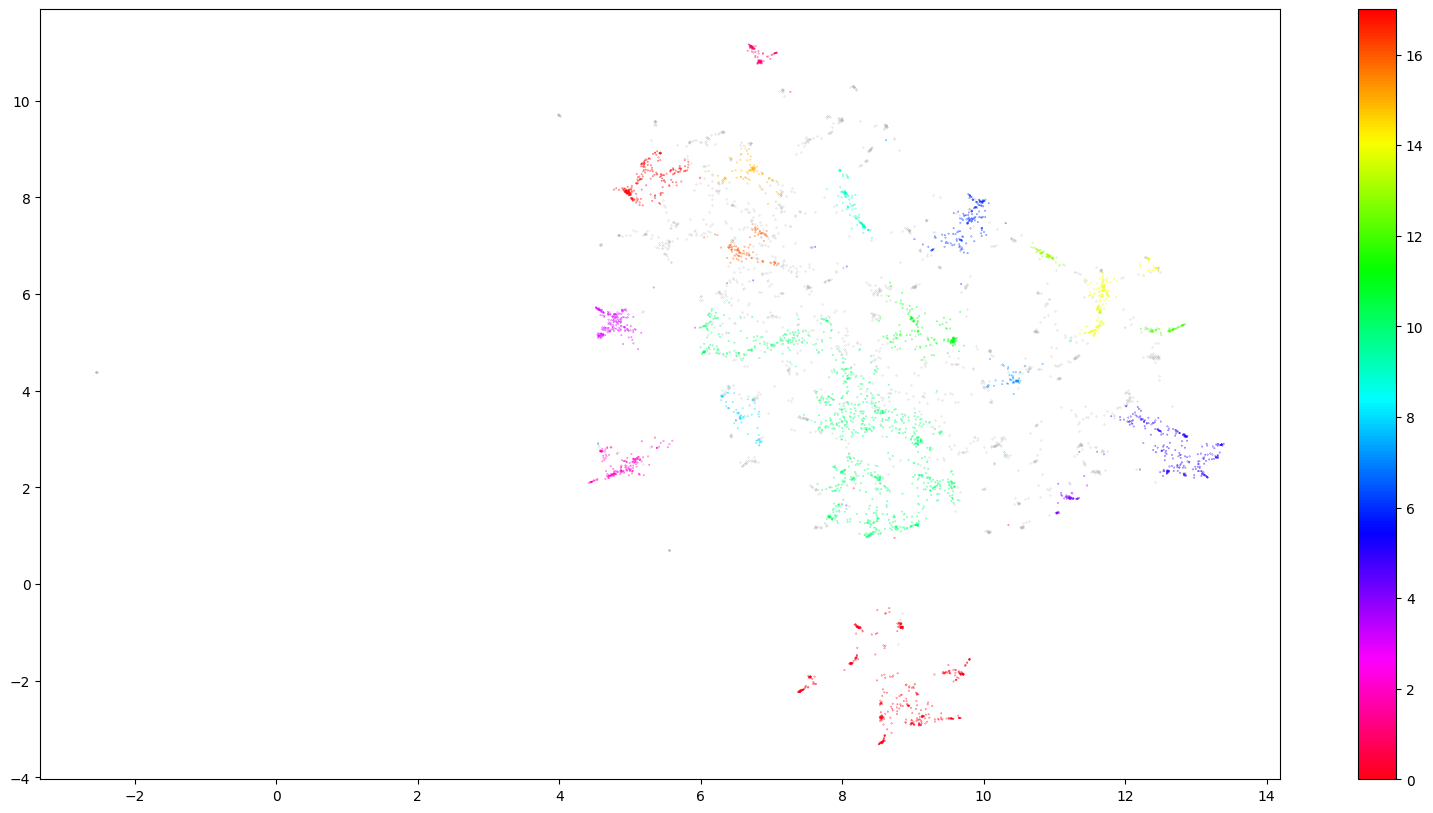

In [61]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

### Topic creation

In [62]:
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [63]:
docs_per_topic

,Topic,Doc
0,-1,"“We’re not talking about him,” former colleagu..."
1,0,Harrison Ford has “still got it” — according t...
2,1,Editor’s Note: Sign up to get this weekly colu...
3,2,Log in to comment on videos and join in on the...
4,3,"New York CNN —\n\nFor a few months in 2017, th..."
5,4,An ally said he did not think the former prime...
6,5,"HIROSHIMA, Japan (AP) — Ukrainian President Vo..."
7,6,From table and chairs sets and modular to para...
8,7,Sign up for CNN’s Wonder Theory science newsle...
9,8,"""Nomadland,"" ""The Crown,"" ""Soul,"" and ""The Que..."


In [64]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

### Topic representation

In [65]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,1664
11,10,993
1,0,476
6,5,258
18,17,211
15,14,190
4,3,186
3,2,178
7,6,165
12,11,159


In [68]:
top_n_words[2]

[('zelda', 0.021708145329423608),
 ('vita', 0.020526774488741305),
 ('nintendo', 0.017170967963081925),
 ('kingdom', 0.016554200934501526),
 ('codes', 0.013332443979891468),
 ('tears', 0.013164937246195),
 ('hyrule', 0.011836360296491887),
 ('smithing', 0.011594172480081813),
 ('cookie', 0.011473362337717915),
 ('switch', 0.010778488765530732),
 ('game', 0.009915734909956836),
 ('legend', 0.00976504907915213),
 ('dragon', 0.00965011856435447),
 ('edition', 0.009107033010820645),
 ('ago', 0.00858080504161326),
 ('characters', 0.008532351470578651),
 ('adventure', 0.008234087040995717),
 ('battle', 0.008152090452313692),
 ('sword', 0.008110534875011795),
 ('mario', 0.008068968202136047)]

After analyzing each topic manually, we came up with the following mappings (number of clusters and indices change at each run, find how to fix the seed to always have the same topics at a given index)

topic_theme = {
    -1: "Other",
    0: "Sports",
    1: "Gaming",
    2: "Fiscal Policy and Government Finance",
    3: "Technology",
    4: "Artificial Intelligence",
    5: "British Politics and International Relations",
    6: "Geopolitics",
    7: "Biological Sciences",
    8: "Automotive",
    9: "Astronomy",
    10: "Fossil-Fuel Industry",
    11: "Environment and Climate",
    12: "Health and Wellness",
    13: "Real Estate and Housing",
    14: "Social Media Content",
    15: "Companies Reports",
    16: "Stocks and Investment",
    17: "Economy",
    18: "Entertainment",
    19: "Miscellaneous"
}

# Multiclass classification

Transformers don't support negative values as labels, so we replace the -1 class with `len(docs_per_topic)-1`

In [ ]:
docs_df = docs_df.replace({"Topic": -1}, len(docs_per_topic)-1)

No preprocessing for BERT, [here](https://datascience.stackexchange.com/questions/113359/why-there-is-no-preprocessing-step-for-training-bert) is why

In [ ]:
from datasets import Dataset, DatasetDict, Features, Value, ClassLabel

In [ ]:
articles_features = Features({'Doc': Value('string'),
                              'Topic': ClassLabel(num_classes=len(docs_per_topic)),
                              'Doc_ID': Value('int32')})

In [ ]:
dataset = Dataset.from_pandas(docs_df, features=articles_features)

In [ ]:
dataset = dataset.rename_column("Topic", "label")

In [ ]:
# 90% train, 10% test + validation
train_testvalid = dataset.train_test_split(test_size=0.1, stratify_by_column="label")
# Split the 10% test + valid in half test, half valid
test_valid = train_testvalid['test'].train_test_split(test_size=0.5, stratify_by_column="label")
# gather everyone if you want to have a single DatasetDict
train_test_valid_dataset = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})

In [ ]:
train_test_valid_dataset

DatasetDict({
    train: Dataset({
        features: ['Doc', 'label', 'Doc_ID'],
        num_rows: 4649
    })
    test: Dataset({
        features: ['Doc', 'label', 'Doc_ID'],
        num_rows: 259
    })
    valid: Dataset({
        features: ['Doc', 'label', 'Doc_ID'],
        num_rows: 258
    })
})

In [ ]:
from transformers import AutoTokenizer

model_version = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_version)

In [ ]:
def tokenize_function(example):
    return tokenizer(example["Doc"], truncation=True)

In [ ]:
tokenized_datasets = train_test_valid_dataset.map(tokenize_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/4649 [00:00<?, ? examples/s]

Map:   0%|          | 0/259 [00:00<?, ? examples/s]

Map:   0%|          | 0/258 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Doc', 'label', 'Doc_ID', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4649
    })
    test: Dataset({
        features: ['Doc', 'label', 'Doc_ID', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 259
    })
    valid: Dataset({
        features: ['Doc', 'label', 'Doc_ID', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 258
    })
})

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## Training

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments("/content/drive/MyDrive/Colab Notebooks/M2_NLP/trained_models",
                                  evaluation_strategy="epoch")

In [ ]:
device_ = torch.cuda.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_version, num_labels=len(docs_per_topic)).to(device_)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [ ]:
import evaluate
from scipy.special import softmax

def compute_metrics (eval_pred):
    f1_metric = evaluate.load("f1")
    recall_metric = evaluate.load("recall")
    precision_metric = evaluate.load("precision")
    accuracy_metric = evaluate.load("accuracy")
    roc_metric = evaluate.load("roc_auc", "multiclass")
    logits, labels = eval_pred
    preds = np.argmax(logits, axis = -1)
    pred_scores = softmax(logits, axis=1)
    
    results = {}
    results.update(accuracy_metric.compute(predictions=preds, references=labels))
    results.update(recall_metric.compute(predictions=preds, references=labels, average="weighted"))
    results.update(precision_metric.compute(predictions=preds, references=labels, average="weighted"))
    results.update(f1_metric.compute(predictions=preds, references=labels, average="weighted"))
    results.update(roc_metric.compute(prediction_scores=pred_scores, references=labels, multi_class="ovr"))
    return results

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["valid"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
result = trainer.train()
result

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1,Roc Auc
1,0.710300,0.955185,0.759690,0.759690,0.769508,0.749267,0.965846
2,0.381200,0.817441,0.813953,0.813953,0.827302,0.807068,0.972171
3,0.186600,0.925580,0.817829,0.817829,0.828667,0.812676,0.960988


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=1746, training_loss=0.3857781649455172, metrics={'train_runtime': 1477.2078, 'train_samples_per_second': 9.441, 'train_steps_per_second': 1.182, 'total_flos': 3670532431607808.0, 'train_loss': 0.3857781649455172, 'epoch': 3.0})

In [ ]:
trainer.save_model("/content/drive/MyDrive/Colab Notebooks/M2_NLP")

## Evaluation

In [ ]:
trainer.evaluate()

{'eval_loss': 0.9255799055099487,
 'eval_accuracy': 0.8178294573643411,
 'eval_recall': 0.8178294573643411,
 'eval_precision': 0.8286674888419076,
 'eval_f1': 0.8126757371062293,
 'eval_roc_auc': 0.9609879381490678,
 'eval_runtime': 9.4038,
 'eval_samples_per_second': 27.436,
 'eval_steps_per_second': 3.509,
 'epoch': 3.0}

## Load saved model

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/Colab Notebooks/M2_NLP")

In [ ]:
device = torch.cuda.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device_)

## Inference

In [ ]:
inputs = tokenizer(train_test_valid_dataset["test"][2]["Doc"], return_tensors="pt", truncation=True).to(device)

with torch.no_grad():
    logits = model(**inputs).logits

In [ ]:
predicted_class_id = logits.argmax().item()
model.config.id2label[predicted_class_id]

'LABEL_19'

In [ ]:
top_n_words[19]

[('sleep', 0.011461576405120416),
 ('covid', 0.011122103094328716),
 ('health', 0.010310192611306772),
 ('disease', 0.0071651007335370885),
 ('patients', 0.007098409555863594),
 ('virus', 0.006794551888643533),
 ('weight', 0.006550636170998724),
 ('drugs', 0.006028174100553724),
 ('symptoms', 0.005740529292799722),
 ('drug', 0.005660415647254097),
 ('vaccines', 0.0056566160565988365),
 ('hearing', 0.005550581047427769),
 ('apnea', 0.005540473481109756),
 ('vaccine', 0.005463078813393765),
 ('vitamin', 0.005433138206407731),
 ('cdc', 0.005064039220830946),
 ('treatment', 0.004901014045518031),
 ('loss', 0.0048707190884980465),
 ('risk', 0.004758677596571365),
 ('study', 0.004577120168315401)]

In [ ]:
train_test_valid_dataset["test"][2]["Doc"]

'I Asked Leading Covid Scientists — Off the Record — About the Virus’s Origins and the ‘Lab Leak’…\n\nHere’s what they told me.'